# Multi-Node Bioinformatics Alignment `pandarallel` Examples with Controlled Number of Progress Bars

In the bioinformatics community, the `pandas` `DataFrame` is a popular tool for holding, manipulating, and performing computations on genomic sequence data and their associated properties.  For larger datasets, the need to parallelize operations on DataFrames motivates the need for tools such as `pandarallel`.  Because `pandarallel` is implemented against the standard Python `multiprocessing` library, this represents an opportunity for `dragon` to accelerate and enable greater scalability to users' code without necessarily requiring them to modify their code or patterns of thinking around their code.

The example proposed uses a variant of NPSR1 linked to moderate/severe (stage III/IV) endometriosis, asthma, and sleep-related disorders. This variant is queried against a small dataset of nucleotide and protein sequences for the closest match. The closeness of the match is determined by the pairwise alignment, the E-value, and the percentage of match coverage. 

In a multi-node `dragon` execution configuration, some nodes may be slower/faster than others and it may be helpful to see the relative progress/speed of one cluster's nodes versus others -- this motivates showing more than just a single progress bar representing all workers.

The use case illustrates how parallel_apply from pandarallel is used for feature engineering for a k-means clustering use case. The features are commonly utilized in bioinformatics. 

In [1]:
!pip install pandarallel
!pip install biopython
!pip install pyalign
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

  Cloning https://github.com/veena-v-g/pandarallel.git to /tmp/pip-req-build-5ix_nhke
  Running command git clone --filter=blob:none --quiet https://github.com/veena-v-g/pandarallel.git /tmp/pip-req-build-5ix_nhke
  Resolved https://github.com/veena-v-g/pandarallel.git to commit 0467c4a733d76db72d987fc03bec4dc1de0f6157
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for dill>=0.3.1 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Using cached dill-0.3.7-py3-none-any.whl.metadata (9.9 kB)
  Obtaining dependency information for pandas>=1 from https://files.pythonhosted.org/packages/83/f0/2765daac3c58165460b127df5c0ef7b3a039f3bfe7ea7a51f3d20b01371b/pandas-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached pandas-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached psutil-5.9.5-cp36-ab

In [3]:
import dragon
import multiprocessing

import cloudpickle

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd

import Bio
from Bio import SeqIO, Entrez
import pyalign
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import os.path
import pandarallel; pandarallel.__version__

'1.6.5'

The NPSR1 variant, rs142885915, is linked to stage III/IV endometriosis. The GenBank record is linked here: https://www.ncbi.nlm.nih.gov/protein/AKI72104.1

In [4]:
Entrez.email = raise Exception("need to set your email address here")
handle = Entrez.efetch(db="protein", id="AKI72104.1", rettype="gb", retmode="text")
read = SeqIO.read(handle, "genbank")
handle.close()
endo_name, endo_transl, endo_descr = str(read.name), str(read.seq), str(read.description)

A subset of the protein database is created that is specific to NPSR1. The database is written to a csv file. If the database exists, it is read from the file. 

In [5]:
if os.path.isfile("NSPR1_proteins_database.csv"):
    aa_df = pd.read_csv("NSPR1_proteins_database.csv", on_bad_lines='skip')
else:
    handle = Entrez.esearch(db="protein", term="npsr1[gene] AND mammals[ORGN]", retmax='100')
    record = Entrez.read(handle)
    aa_identifiers = list(record["IdList"])
    handle.close()
    aa_id_names, aa_sequences, aa_descriptions = [endo_name], [endo_transl], [endo_descr]
    for idx, seq_id in enumerate(aa_identifiers):
        try:
            handle = Entrez.efetch(db="protein", id=seq_id,  retmode='text', rettype='gb')
            read = SeqIO.read(handle, "genbank")
            aa_id_names.append(str(read.name))
            aa_sequences.append(str(read.seq))
            aa_descriptions.append(str(read.description))
            handle.close()
        except:
            pass
    aa_df = pd.DataFrame(list(zip(aa_id_names, aa_sequences, aa_descriptions)), columns=['ID Name','Sequence', 'Description'])
    aa_df.to_csv("NSPR1_proteins_database.csv", index=False)

In [6]:
aa_df

,ID Name,Sequence,Description
0,AKI72104,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,"NPSR1, partial [synthetic construct]"
1,XP_058580602,MPANLTEGSPDSKGSSGTTQTPDASPALCTETMTFTEVVEGEEWGS...,neuropeptide S receptor [Neofelis nebulosa]
2,XP_012781596,MPANWTEGSTTSNQTTLTLGLSPVTCTATVTFTEVVDQEEWGSFYY...,neuropeptide S receptor isoform X2 [Ochotona p...
3,XP_004582431,MPANWTEGSTTSNQTTLTLGLSPVTCTATVTFTEVVDQEEWGSFYY...,neuropeptide S receptor isoform X1 [Ochotona p...
4,NP_783609,MPANLTEGSFHANQTVPMLDSSPVACTEIVTFTEALVAEEWGSFYS...,neuropeptide S receptor [Mus musculus]
...,...,...,...
96,XP_051052880,MPANLTEGNSHANQTVACTEIVTFTEVLAVEEGGSFYSSFKTEQLI...,neuropeptide S receptor [Phodopus roborovskii]
97,XP_049749630,MPANLTEGSPDSSGTTQMLDSSPAACSETVTVTEVVEGEEWGSFYS...,neuropeptide S receptor isoform X3 [Elephas ma...
98,XP_049749629,MPANLTEGSPDSSGTTQMLDSSPAACSETVTVTEVVEGEEWGSFYS...,neuropeptide S receptor isoform X2 [Elephas ma...
99,XP_049749628,MPANLTEGSPDSSGTTQMLDSSPAACSETVTVTEVVEGEEWGSFYS...,neuropeptide S receptor isoform X1 [Elephas ma...


The use of a global variable inside a lambda function demonstrates key functionality from `cloudpickle` that is not otherwise available through `dill`. There is one progress bar for each worker. 

In [7]:
multiprocessing.set_start_method("dragon")
pandarallel.core.dill = cloudpickle
ctx = multiprocessing.get_context("dragon")
ctx.Manager = type("PMgr", (), {"Queue": ctx.Queue})
pandarallel.core.CONTEXT = ctx
pandarallel.pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


The pairwise alignment algorithm from PyAlign can be used for either nucleotide or amino acid sequences to find similar regions in two sequences. The pairwise alignment score can point to similar functions, evolutionary origins, and structural elements in the two sequences. The higher the score, the better the alignment.

In [8]:
def alignment_algorithm(sequence_1, sequence_2, gap):
    alignment = pyalign.global_alignment(sequence_1, sequence_2, gap_cost=gap, eq=1, ne=-1)
    return alignment.score

The E value is used to determine the number of hits one can expect to see when searching the database. As the score increases, the E value decreases. This means there is a reduction in noise. The smaller the E-value, the better the match. The E value is calculated with using the Jaccard distance.

In [9]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return 1.0 - float(intersection) / union

The new column of values in our pandas.DataFrame that shows the pairwise alignment from PyAlign.

In [10]:
start = time.monotonic()
aa_df['PyAlign Alignment Score'] = aa_df['Sequence'].parallel_apply(lambda seq2: alignment_algorithm(endo_transl, seq2, gap=0))
stop = time.monotonic()
aa_functions, aa_bar_num, aa_tot_time = ['PyAlign Alignment Score'],[10],[stop-start]
aa_df.sort_values(by=['PyAlign Alignment Score'],  inplace = True, ascending=False)
aa_df = aa_df[['ID Name','Sequence', 'PyAlign Alignment Score', 'Description']]
aa_df.head()

,ID Name,Sequence,PyAlign Alignment Score,Description
0,AKI72104,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,377.0,"NPSR1, partial [synthetic construct]"
40,XP_004045349,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,373.0,neuropeptide S receptor isoform X2 [Gorilla go...
32,XP_003812004,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,372.0,neuropeptide S receptor isoform X1 [Pan paniscus]
62,XP_054352657,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,371.0,neuropeptide S receptor isoform X1 [Pongo pygm...
57,XP_024105546,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,370.0,neuropeptide S receptor isoform X1 [Pongo abelii]


The new column of values in our pandas.DataFrame that shows the E value for the sequences.

In [11]:
start = time.monotonic()
aa_df['E Value'] = aa_df['Sequence'].parallel_apply(lambda seq2: jaccard_similarity(list(endo_transl), list(seq2)))
stop = time.monotonic()
aa_functions.append('E Value')
aa_bar_num.append(10)
aa_tot_time.append(stop-start)
aa_df.sort_values(by=['E Value'],  inplace = True, ascending=True)
aa_df = aa_df[['ID Name','Sequence', 'PyAlign Alignment Score','E Value', 'Description']]
aa_df.head()

/tmp/ipykernel_19178/1610342582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_df['E Value'] = aa_df['Sequence'].parallel_apply(lambda seq2: jaccard_similarity(list(endo_transl), list(seq2)))
/tmp/ipykernel_19178/1610342582.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_df.sort_values(by=['E Value'],  inplace = True, ascending=True)


,ID Name,Sequence,PyAlign Alignment Score,E Value,Description
0,AKI72104,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,377.0,0.0,"NPSR1, partial [synthetic construct]"
58,XP_054352661,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,282.0,0.0,neuropeptide S receptor isoform X5 [Pongo pygm...
45,XP_055149426,MPANFTEGSFDSSGTGQTLDSSPVACTDTVTFTEVVEGKEWGSFYY...,282.0,0.0,neuropeptide S receptor isoform X4 [Symphalang...
33,XP_001365641,MQVNGTEGGRAVNGTMEPLDAQPLDTCAETVTSPEGAEQEEWGSFY...,294.0,0.0,neuropeptide S receptor [Monodelphis domestica]
89,XP_024418833,MPASLTEGSPNTTETAQTPDSQAAACFPTSFTEVVEEEAWGSFYSS...,298.0,0.0,neuropeptide S receptor [Desmodus rotundus]


For this new column in the pandas dataframe created from parallel_apply, we will use the sequencing coverage percentage which provides the percentage of coverage of the aligned sequence reads. The final protein dataframe output shows the alignment, E value, and percentage coverage ordered by percentage coverage and E value. The best matches line up with the query sequence.

In [12]:
start = time.monotonic()
aa_df['Percentage Coverage'] = aa_df['PyAlign Alignment Score'].parallel_apply(lambda match: 100*(float(match/len(endo_transl))))
stop = time.monotonic()
aa_functions.append('Percentage Coverage')
aa_bar_num.append(10)
aa_tot_time.append(stop-start)
aa_df.sort_values(by=['Percentage Coverage'],  inplace = True, ascending=False)
aa_df = aa_df[['ID Name','Sequence', 'PyAlign Alignment Score','E Value', 'Percentage Coverage', 'Description']]
aa_df

,ID Name,Sequence,PyAlign Alignment Score,E Value,Percentage Coverage,Description
0,AKI72104,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,377.0,0.000000,100.000000,"NPSR1, partial [synthetic construct]"
40,XP_004045349,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,373.0,0.000000,98.938992,neuropeptide S receptor isoform X2 [Gorilla go...
32,XP_003812004,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,372.0,0.000000,98.673740,neuropeptide S receptor isoform X1 [Pan paniscus]
62,XP_054352657,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,371.0,0.000000,98.408488,neuropeptide S receptor isoform X1 [Pongo pygm...
57,XP_024105546,MPANFTEGSFDSSGTGQTLDSSPVACTETVTFTEVVEGKEWGSFYY...,370.0,0.000000,98.143236,neuropeptide S receptor isoform X1 [Pongo abelii]
...,...,...,...,...,...,...
69,XP_053074217,MAPDLVCRVVRYLQVVLLYASTYVLVSLSIDRYHAIVYPMKFLQGE...,221.0,0.000000,58.620690,neuropeptide S receptor [Acinonyx jubatus]
71,XP_053074215,MAPDLVCRVVRYLQVVLLYASTYVLVSLSIDRYHAIVYPMKFLQGE...,221.0,0.000000,58.620690,neuropeptide S receptor [Acinonyx jubatus]
70,XP_053074216,MAPDLVCRVVRYLQVVLLYASTYVLVSLSIDRYHAIVYPMKFLQGE...,221.0,0.000000,58.620690,neuropeptide S receptor [Acinonyx jubatus]
64,XP_017168907,MKFLQGEKQAKVLIGIAWSLSFLFSIPTLIIFGKRTLSNGEVQCWA...,183.0,0.000000,48.541114,neuropeptide S receptor isoform X2 [Mus musculus]


The time for the pandarallel parallel_apply for the respective applications is displayed in the pandas dataframe below.  

In [13]:
std_time_df = pd.DataFrame(list(zip(aa_functions, aa_bar_num, aa_tot_time)), columns=['Pandarallel Function','Number of Bars', 'Time'])
std_time_sum = std_time_df['Time'].sum()
std_time_df.loc[len(std_time_df.index)] = ['Total Time for All Dragon Multiprocessing Pandarallel Processes (Amino Acids)', "N/A", std_time_sum]
std_time_df

,Pandarallel Function,Number of Bars,Time
0,PyAlign Alignment Score,10,7.031509
1,E Value,10,6.835784
2,Percentage Coverage,10,7.396781
3,Total Time for All Dragon Multiprocessing Pand...,N/A,21.264074


The correlation for the variables in the nucleotide pandas dataframe are plotted, and the variables for k-means clustering are identified.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/pytho

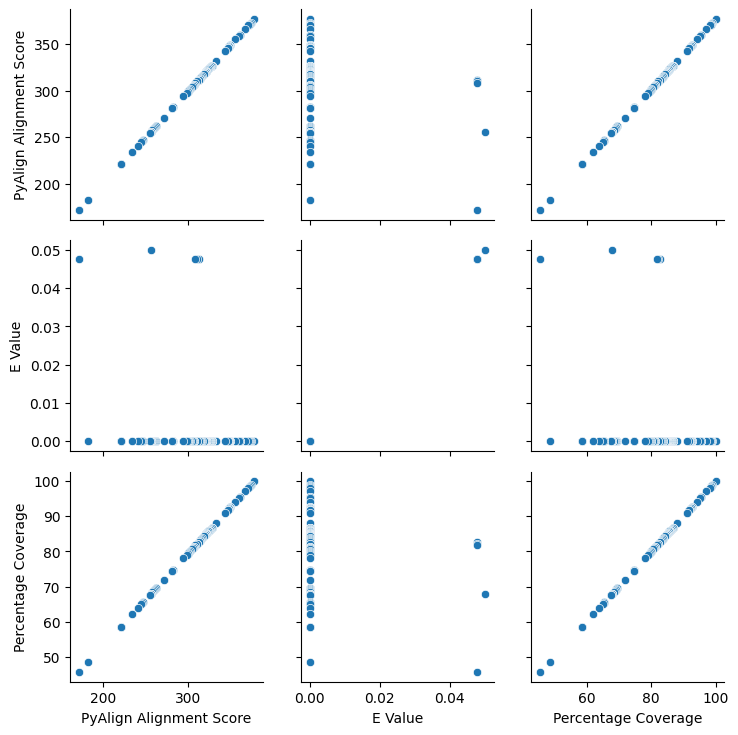

In [14]:
sns.PairGrid(aa_df).map(sns.scatterplot);

The x-axis is the PyAlign Alignment Score, and the y-axis is percentage coverage. The scatterplot function from the seaborn library is used for k-means clustering using the variables identified.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='PyAlign Alignment Score', ylabel='Percentage Coverage'>

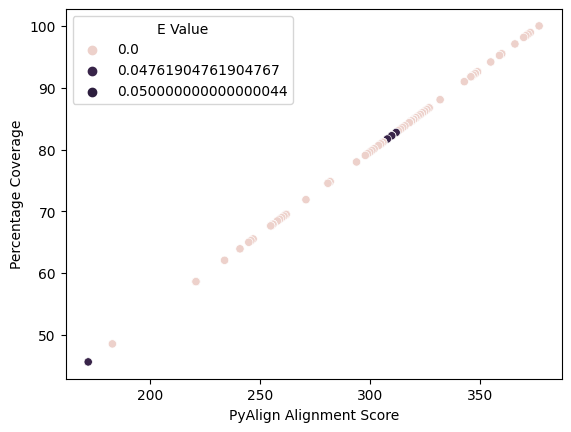

In [15]:
sns.scatterplot(data = aa_df[['PyAlign Alignment Score', 'E Value', 'Percentage Coverage']], x = 'PyAlign Alignment Score', y = 'Percentage Coverage', hue = 'E Value')

The cluster number is determined from the elbow method and the default arguments for the k-means algorithm.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/gho

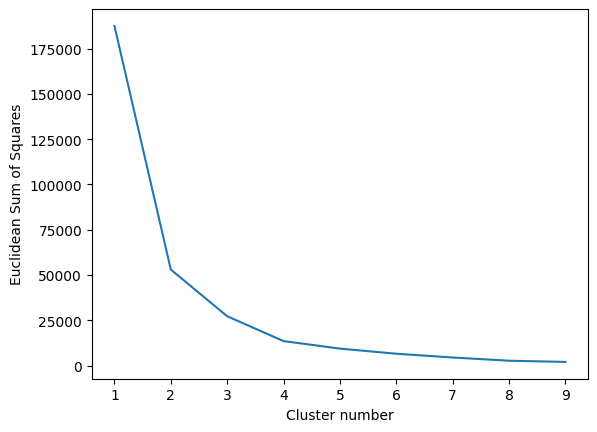

In [16]:
X = np.array(aa_df.loc[:,['PyAlign Alignment Score', 'Percentage Coverage']])

euclidean = []
for i in range(1, 10):
    model = KMeans(n_clusters = i)
    model.fit(X)                              
    euclidean.append(model.inertia_)

plt.plot(range(1, 10), euclidean)
plt.xlabel('Cluster number')
plt.ylabel('Euclidean Sum of Squares')
plt.show()

The k-means algorithm is plotted, and the default arguments for the k-means algorithm is used. 

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


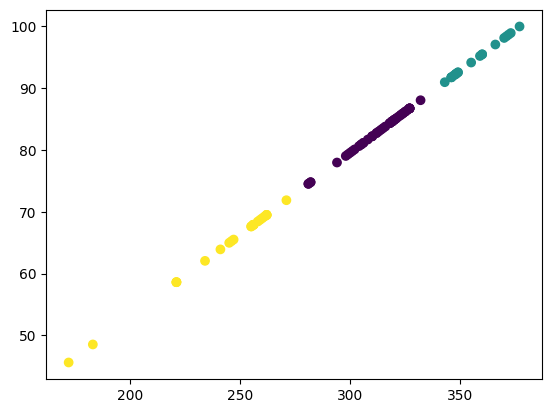

In [17]:
model = KMeans(n_clusters=3).fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))